# Flood Prediction Algorithm

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, MaxPooling1D

In [ ]:
file_path = '/content/open_flood_risk_by_postcode.csv'
df = pd.read_csv(file_path)
df.head()

,TR23 0PR,\N,None,\N.1,\N.2,\N.3,87897,15021,49.953605,-6.352647
0,TR23 0WA,\N,NaN,\N,\N,\N,87903,15077.0,49.954111,-6.352609
1,TR22 0PL,\N,NaN,\N,\N,\N,88364,8478.0,49.895171,-6.340873
2,TR24 0QE,\N,NaN,\N,\N,\N,88849,15298.0,49.956586,-6.339638
3,TR24 0QL,\N,NaN,\N,\N,\N,88857,15392.0,49.957433,-6.339603
4,TR24 0QB,\N,NaN,\N,\N,\N,88887,15424.0,49.957736,-6.339211


In [ ]:
df.columns = ['postcode', 'fid', 'prob_4band', 'suitability', 'pub_date', 'risk_for_insurance_sop',
              'easting', 'northing', 'latitude', 'longitude']
df.fillna(method='ffill', inplace=True)
df['risk_for_insurance_sop'] = pd.to_numeric(df['risk_for_insurance_sop'], errors='coerce').fillna(0).astype(int)
features = df[['easting', 'northing', 'latitude', 'longitude']]
target = df['risk_for_insurance_sop']

In [ ]:
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)
features_scaled = features_scaled.reshape((features_scaled.shape[0], features_scaled.shape[1], 1))
X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=0.2, random_state=42)
print(f'Training set shape: {X_train.shape}, {y_train.shape}')
print(f'Testing set shape: {X_test.shape}, {y_test.shape}')

Training set shape: (123058, 4, 1), (123058,)
Testing set shape: (30765, 4, 1), (30765,)


In [ ]:
model = Sequential([
    Conv1D(32, kernel_size=2, activation='relu', input_shape=(X_train.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(10, activation='relu'),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=25, batch_size=10, validation_data=(X_test, y_test))


Epoch 1/25
12306/12306 [==============================] - 45s 4ms/step - loss: 0.0063 - accuracy: 0.9999 - val_loss: 2.6184e-09 - val_accuracy: 1.0000
Epoch 2/25
12306/12306 [==============================] - 32s 3ms/step - loss: 6.3378e-10 - accuracy: 1.0000 - val_loss: 1.2702e-10 - val_accuracy: 1.0000
Epoch 3/25
12306/12306 [==============================] - 30s 2ms/step - loss: 6.9076e-11 - accuracy: 1.0000 - val_loss: 3.6520e-11 - val_accuracy: 1.0000
Epoch 4/25
12306/12306 [==============================] - 33s 3ms/step - loss: 2.7523e-11 - accuracy: 1.0000 - val_loss: 2.0032e-11 - val_accuracy: 1.0000
Epoch 5/25
12306/12306 [==============================] - 31s 3ms/step - loss: 1.6980e-11 - accuracy: 1.0000 - val_loss: 1.3687e-11 - val_accuracy: 1.0000
Epoch 6/25
12306/12306 [==============================] - 32s 3ms/step - loss: 1.2237e-11 - accuracy: 1.0000 - val_loss: 1.0353e-11 - val_accuracy: 1.0000
Epoch 7/25
12306/12306 [==============================] - 32s 3ms/step - l

In [ ]:
from tabulate import tabulate
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy:.2f}')
y_pred = model.predict(X_test)
y_pred_binary = (y_pred.flatten() > 0.5).astype(int)
results = pd.DataFrame({'Actual': y_test.values, 'Predicted': y_pred_binary})
print(tabulate(results.head(10), headers='keys', tablefmt='psql'))

962/962 [==============================] - 2s 2ms/step - loss: 1.7950e-12 - accuracy: 1.0000
Test Accuracy: 1.00
962/962 [==============================] - 2s 2ms/step
+----+----------+-------------+
|    |   Actual |   Predicted |
|----+----------+-------------|
|  0 |        0 |           0 |
|  1 |        0 |           0 |
|  2 |        0 |           0 |
|  3 |        0 |           0 |
|  4 |        0 |           0 |
|  5 |        0 |           0 |
|  6 |        0 |           0 |
|  7 |        0 |           0 |
|  8 |        0 |           0 |
|  9 |        0 |           0 |
+----+----------+-------------+


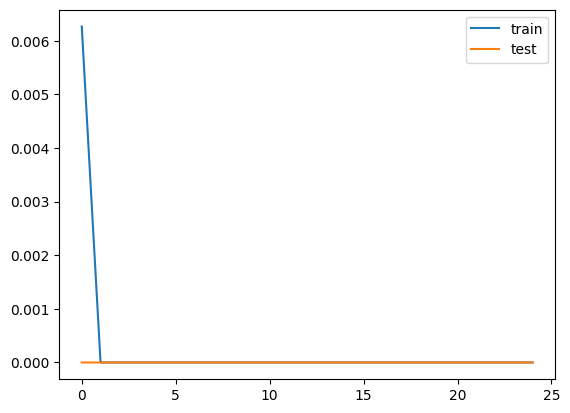

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

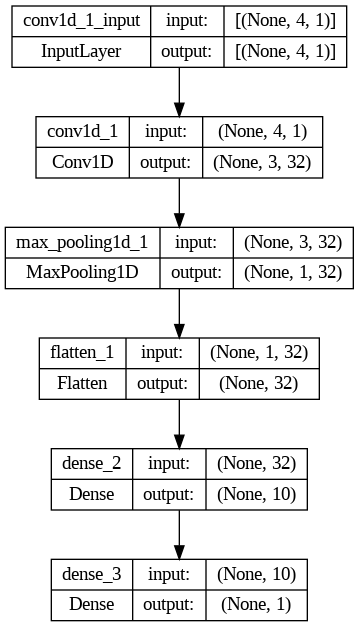

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

(1, 1)


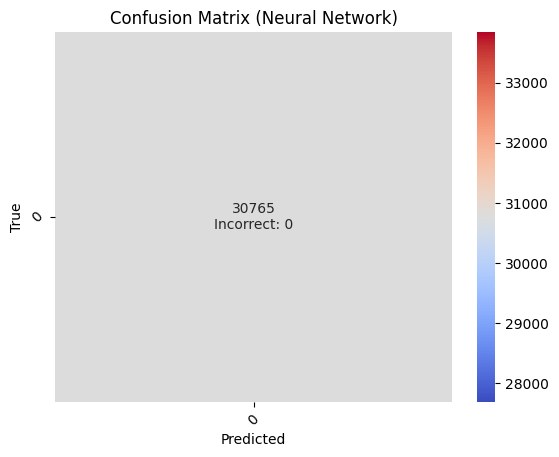

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
conf_mat = confusion_matrix(y_test, y_pred_binary)
print(conf_mat.shape)
incorrect_predictions = conf_mat.copy()
np.fill_diagonal(incorrect_predictions, 0)
annot = np.empty_like(conf_mat, dtype=object)
for i in range(conf_mat.shape[0]):
    for j in range(conf_mat.shape[1]):
        annot[i, j] = f'{conf_mat[i, j]}\nIncorrect: {incorrect_predictions[i, j]}'

ax = sns.heatmap(conf_mat, annot=annot, fmt='', cmap='coolwarm')
labels = ['No', 'Yes']

if conf_mat.shape == (2, 2):
    ax.set_xticklabels(labels, rotation=45)
    ax.set_yticklabels(labels, rotation=45)
else:
    ax.set_xticklabels(range(conf_mat.shape[1]), rotation=45)
    ax.set_yticklabels(range(conf_mat.shape[0]), rotation=45)
ax.set(xlabel='Predicted', ylabel='True', title='Confusion Matrix (Neural Network)')
plt.show()

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 3, 32)             96        
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 1, 32)             0         
 g1D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 10)                330       
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                                 
Total params: 437 (1.71 KB)
Trainable params: 437 (1.71 KB)
Non-trainable params: 0 (0.00 Byte)
________________________